In [ ]:
!pip install kornia==0.3.1
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pytorch-lightning==0.9.0rc2  
!pip install neptune-client

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import argparse
import multiprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from PIL import Image

from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl

import neptune
from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

import sys
sys.path.append('/content/drive/My Drive/hateful_memes/')
from byol_pytorch import BYOL

from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from sklearn.cluster import KMeans, DBSCAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
neptune.init(api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNWYyMzI4ZTYtYmNhYy00MTVjLTg3ZTQtMGJhMzRkNmNiNTBiIn0=',
             project_qualified_name='onopkosonja/byol')

### Hyperparameters

In [3]:
def get_model(version, pretrained):
    pr_flag = 'pretrained' if pretrained else 'not_pretrained'

    if version == 18:
      net = models.resnet18(pretrained=pretrained)
      save_name = 'resnet18_' + pr_flag

    elif version == 50:
      net = models.resnet50(pretrained=pretrained)
      save_name = 'resnet50_' + pr_flag
      
    return net, save_name

In [4]:
RESNET, SAVE_NAME = get_model(50, False)
BATCH_SIZE   = 32
EPOCHS       = 1000
LR           = 3e-4
NUM_GPUS     = 1
IMAGE_SIZE   = 256
IMAGE_EXTS   = ['.png']
NUM_WORKERS  = multiprocessing.cpu_count()

### Classes for training

In [6]:
# pytorch lightning module

class SelfSupervisedLearner(pl.LightningModule):
    def __init__(self, net, **kwargs):
        super().__init__()
        self.learner = BYOL(net, **kwargs)

    def forward(self, images):
        return self.learner(images)

    def training_step(self, images, _):
        loss = self.forward(images)
        return {'loss': loss} 

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.logger.experiment.log_metric('train_loss', avg_loss)
        return {'train_loss': avg_loss}

    def validation_step(self, images, _):
        loss = self.forward(images)
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
         avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
         self.logger.experiment.log_metric('val_loss', avg_loss)
         return {'val_loss': avg_loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LR)

    def on_before_zero_grad(self, _):
        self.learner.update_moving_average()

# images dataset

def expand_greyscale(t):
    return t.expand(3, -1, -1)

class ImagesDataset(Dataset):
    def __init__(self, folder, image_size):
        super().__init__()
        self.folder = folder
        self.paths = []
        print(folder)

        for path in Path(f'{folder}').glob('**/*'):
            _, ext = os.path.splitext(path)
            if ext.lower() in IMAGE_EXTS:
                self.paths.append(path)

        print(f'{len(self.paths)} images found')

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Lambda(expand_greyscale)
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path)
        img = img.convert('RGB')
        return self.transform(img)

### Dataloaders

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

TRAIN_DATASET = ImagesDataset('/content/drive/My Drive/hateful_memes/data/train/', IMAGE_SIZE) 
TRAIN_LOADER = DataLoader(TRAIN_DATASET, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

VAL_DATASET = ImagesDataset('/content/drive/My Drive/hateful_memes/data/val/', IMAGE_SIZE)
VAL_LOADER = DataLoader(VAL_DATASET, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

image_folder = ImageFolder('/content/drive/My Drive/hateful_memes/data/train/', transform=data_transform)
DATALOADER_FROM_IMG_FODLER = DataLoader(image_folder, batch_size=BATCH_SIZE)

### Training

In [ ]:
model = SelfSupervisedLearner(
    RESNET,
    image_size = IMAGE_SIZE,
    hidden_layer = 'avgpool',
    projection_size = 256,
    projection_hidden_size = 4096,
    moving_average_decay = 0.99)

checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/hateful_memes/checkpoints/' + SAVE_NAME + '_{epoch}',
    save_top_k = 10, monitor='val_loss')

neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNWYyMzI4ZTYtYmNhYy00MTVjLTg3ZTQtMGJhMzRkNmNiNTBiIn0=",
    project_name="onopkosonja/byol",
    experiment_name="resnet18_not_pretrained")

trainer = pl.Trainer(logger=neptune_logger, gpus=NUM_GPUS, max_epochs=EPOCHS, checkpoint_callback=checkpoint_callback,
                     ,resume_from_checkpoint='/content/drive/My Drive/hateful_memes/checkpoints/' + SAVE_NAME + '_epoch=139.ckpt')
trainer.fit(model, TRAIN_LOADER, VAL_LOADER)

### Saving embeddings

In [11]:
def save_embeddings(model_name, epoch=0, val=False):
    model = get_online_encoder(model_name, epoch)
    model.to(device)
    model.eval()

    embs = []
    for imgs in tqdm(iter(DATALOADER_FROM_IMG_FODLER)):
        with torch.no_grad():
            imgs_tensor = imgs[0]
            imgs_tensor = imgs_tensor.to(device)
            emb = model(imgs_tensor)
        embs.extend(emb)
        
    embs = np.array([emb.cpu().numpy() for emb in embs])
    embs = embs.squeeze()

    embedding_path = '/content/drive/My Drive/hateful_memes/embeddings/'
    val_flag = '_val' if val else ''

    if model_name == 'resnet18':
      emb_file = embedding_path + model_name + val_flag + '.npy' 
      with open(emb_file, 'wb') as f:
        np.save(f, embs)
    
    else:
      emb_file = embedding_path + model_name + '_epoch={}' +  + val_flag + '.npy'.format(epoch)
      with open(emb_file, 'wb') as f:
          np.save(f, embs)

    print(f'Saved embeddings for {model_name} trained for {epoch} epochs to {emb_file} file')


def get_online_encoder(model_name, epoch):
    if model_name == 'softmax_resnet18':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Sequential(model.fc , nn.Softmax(dim=1))
        return model
    
    elif model_name == 'softmax_resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Sequential(model.fc , nn.Softmax(dim=1))
        return model
    
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

    else:
      checkpoint_path = '/content/drive/My Drive/hateful_memes/checkpoints/' + model_name + '_epoch={}.ckpt'.format(epoch)
      checkpoint = torch.load(checkpoint_path)
      print(f'Loaded {checkpoint_path} checkpoint.')

      byol = SelfSupervisedLearner(
        RESNET,
        image_size = IMAGE_SIZE,
        hidden_layer = 'avgpool',
        projection_size = 256,
        projection_hidden_size = 4096,
        moving_average_decay = 0.99)

      byol.load_state_dict(checkpoint['state_dict'])
      model = byol.learner.online_encoder.net
      
    model = nn.Sequential(*(list(model.children())[:-1]))
    return model

In [ ]:
save_embeddings(model_name='resnet50')

### T-SNE

In [ ]:
def get_tsne(model_name, epoch, val=False):
  embedding_path = '/content/drive/My Drive/hateful_memes/embeddings/'
  val_flag = '_val' if val else ''

  with open(embedding_path + model_name + '_epoch=0.npy' + val_flag, 'rb') as f:
    random_emb = np.load(f)

  with open(embedding_path + model_name + '_epoch={}.npy'.format(epoch) + val_flag, 'rb') as f:
    trained_emb = np.load(f)

  with open(embedding_path + 'labels' + val_flag + '.npy', 'rb') as f:
    labels = np.load(f)

  tsne_random = TSNE()
  X_random = tsne_random.fit_transform(random_emb)

  tsne_trained = TSNE()
  X_trained = tsne_trained.fit_transform(trained_emb)

  return plot_tsne([0, epoch], X_random, X_trained, labels)

def plot_tsne(epochs, tsne_random, tsne_trained, labels):
  tsne = [tsne_random, tsne_trained]

  fig = plt.figure(figsize=(20, 10))
  for i, t in enumerate(tsne):
    plt.subplot(1, 2, i + 1)
    plt.title('t-sne for {} after {} epoch'.format(SAVE_NAME, epochs[i]))
    sns.scatterplot(t[:,0], t[:,1], hue=labels)
  plt.show()

#### BYOL with not pretrained resnet50

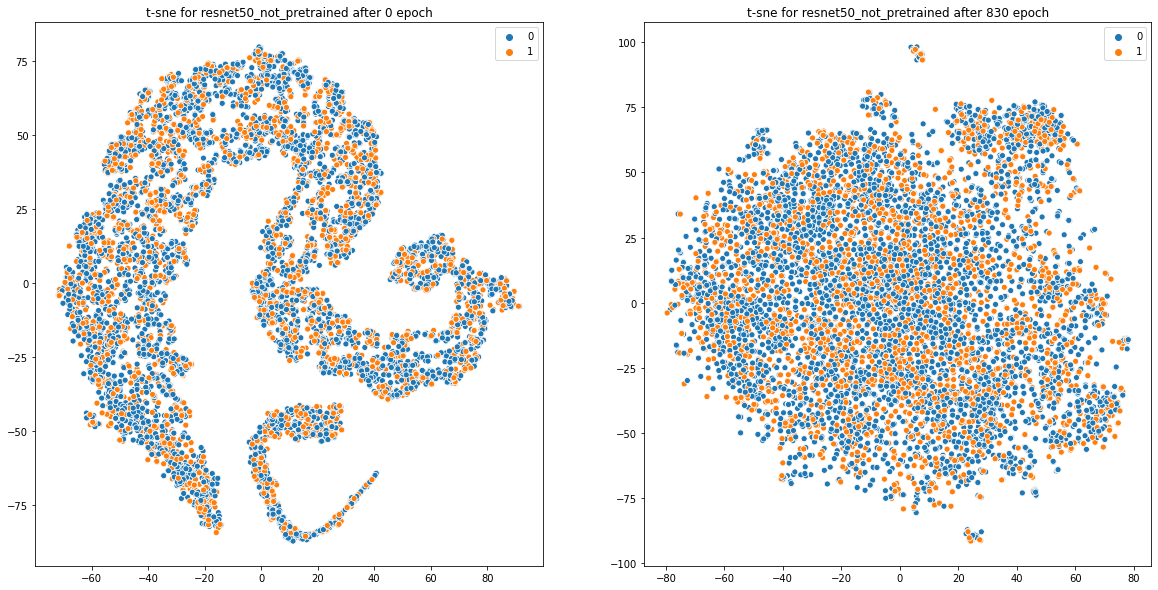

In [ ]:
 get_tsne('resnet50_not_pretrained', 830)

### KNN

In [19]:
def find_nearest_neighbors(model, epoch=0, n_neighbors=5):
  embedding_path = '/content/drive/My Drive/hateful_memes/embeddings/'
  if model == 'resnet50':
    with open(embedding_path + model + '.npy', 'rb') as f:
      emb = np.load(f)
  
  else:
    with open(embedding_path + model + '_epoch={}.npy'.format(epoch), 'rb') as f:
      emb = np.load(f)
    
  nbrs = NearestNeighbors(n_neighbors=n_neighbors+1)
  nbrs.fit(emb)

  _, indices = nbrs.kneighbors(emb)
  return indices

def plot_knn_examples(knn_idx, val=False):
  embedding_path = '/content/drive/My Drive/hateful_memes/embeddings/'
  val_flag = '_val' if val else ''
  with open(embedding_path + 'labels' + val_flag + '.npy', 'rb') as f:
    labels = np.load(f)

  n, k = knn_idx.shape

  for i, imgs_idx in enumerate(knn_idx):
    fig = plt.figure(figsize=(20, 10))

    for j, img_idx in enumerate(imgs_idx):
      plt.subplot(n, k, i * k + j + 1)
      img_folder_idx = knn_idx[i][j]
      img_path, _ = DATALOADER_FROM_IMG_FODLER.dataset.samples[img_folder_idx]
      img_label = labels[img_folder_idx]
      img = plt.imread(img_path)
      plt.title('№ {}, label {}'.format(img_path.rsplit('/')[-1], img_label))
      plt.imshow(img)
  plt.show()


#### BYOL with not pretrained resnet50

In [20]:
random_img = np.random.randint(0, len(TRAIN_DATASET), 5)

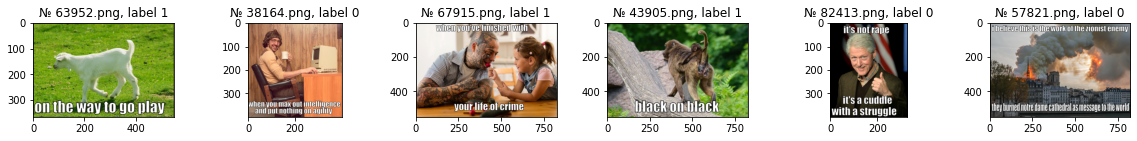

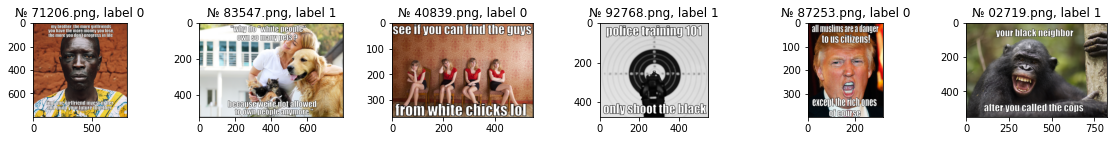

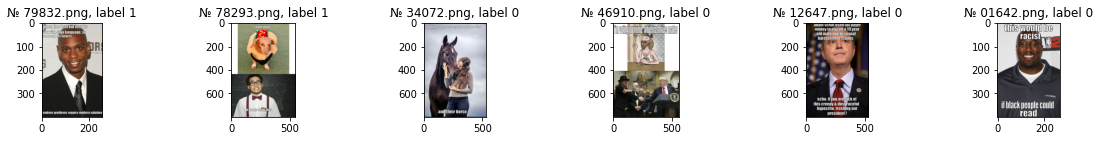

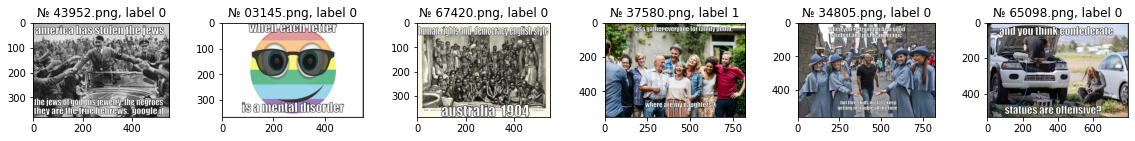

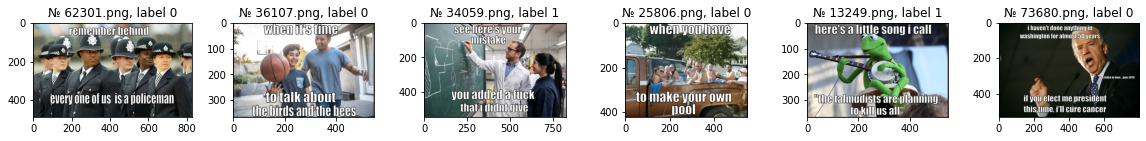

In [22]:
model = 'resnet50_not_pretrained'
knn_idx = find_nearest_neighbors(model, epoch=0)
plot_knn_examples(knn_idx[random_img])

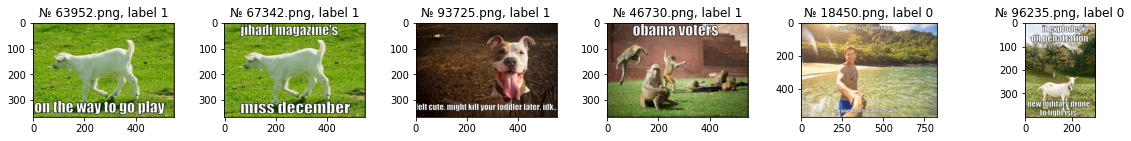

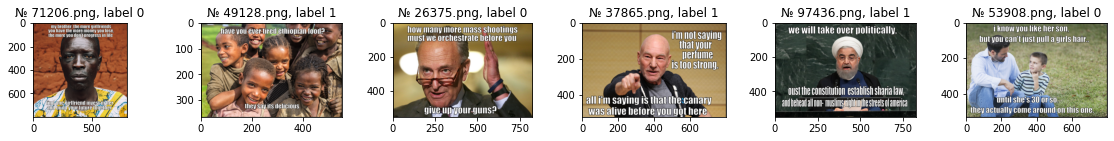

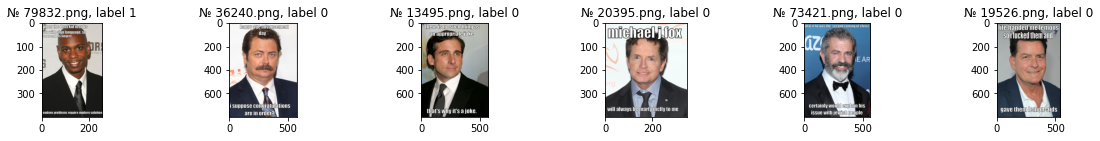

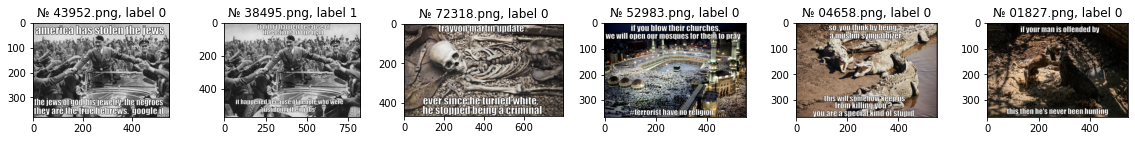

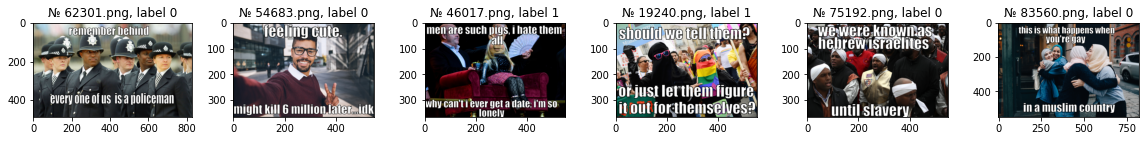

In [23]:
knn_idx = find_nearest_neighbors(model, epoch=830)
plot_knn_examples(knn_idx[random_img])